# **Versión 6: Learning Rate Adaptativo y Early Stopping**
**Gabriela Chimali Nava Ramírez | A01710530**

08/11/2025

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import json
import os

In [2]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print("GPU Details:", tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available: 1
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
strategy = tf.distribute.MirroredStrategy()
print(f"Number of GPUs being used: {strategy.num_replicas_in_sync}")

Number of GPUs being used: 1


## **1. Carga de datos**

In [4]:
train_path = r"/kaggle/input/cards-image-datasetclassification/train"
test_path = r"/kaggle/input/cards-image-datasetclassification/test"
validation_path = r"/kaggle/input/cards-image-datasetclassification/valid"

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Data Augmentation sólo para TRAIN
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.05,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode ="categorical"
)

val_generator = val_datagen.flow_from_directory(
    validation_path,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = val_datagen.flow_from_directory(
    test_path,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


## **2. Construcción del Modelo**

In [6]:
class_names = sorted(os.listdir(train_path))
print(f"Nombres de las clases encontradas: {class_names}")
print(f"Número total de clases: {len(class_names)}")

Nombres de las clases encontradas: ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']
Número

### **2.1. Declaración del modelo**

In [7]:
NUM_CLASSES = 53
IMG_SIZE = (224,224)

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
])

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

callbacks = [early_stop, reduce_lr]

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### **2.2. Compilación del modelo**

In [8]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## **3. Entrenamiento**

In [9]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)

if early_stop.stopped_epoch > 0:
    print(f"\n>> Entrenamiento detenido por EarlyStopping en la época {early_stop.stopped_epoch + 1}.")
else:
    print("\n>> Entrenamiento completado.")

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


239/239 ━━━━━━━━━━━━━━━━━━━━ 168s 641ms/step - accuracy: 0.1294 - loss: 3.7733 - val_accuracy: 0.3547 - val_loss: 2.0953 - learning_rate: 0.0010
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 97s 392ms/step - accuracy: 0.2980 - loss: 2.4928 - val_accuracy: 0.4906 - val_loss: 1.7770 - learning_rate: 0.0010
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 96s 389ms/step - accuracy: 0.3773 - loss: 2.1085 - val_accuracy: 0.5208 - val_loss: 1.6088 - learning_rate: 0.0010
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 96s 391ms/step - accuracy: 0.4163 - loss: 1.9803 - val_accuracy: 0.5057 - val_loss: 1.6278 - learning_rate: 0.0010
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 95s 385ms/step - accuracy: 0.4408 - loss: 1.8345 - val_accuracy: 0.4830 - val_loss: 1.5847 - learning_rate: 0.0010
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 95s 384ms/step - accuracy: 0.4694 - loss: 1.7553 - val_accuracy: 0.4943 - val_loss: 1.5299 - learning_rate: 0.0010
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 94s 382ms/step - accuracy: 0.4850 - loss

## **4. Métricas del entrenamiento**

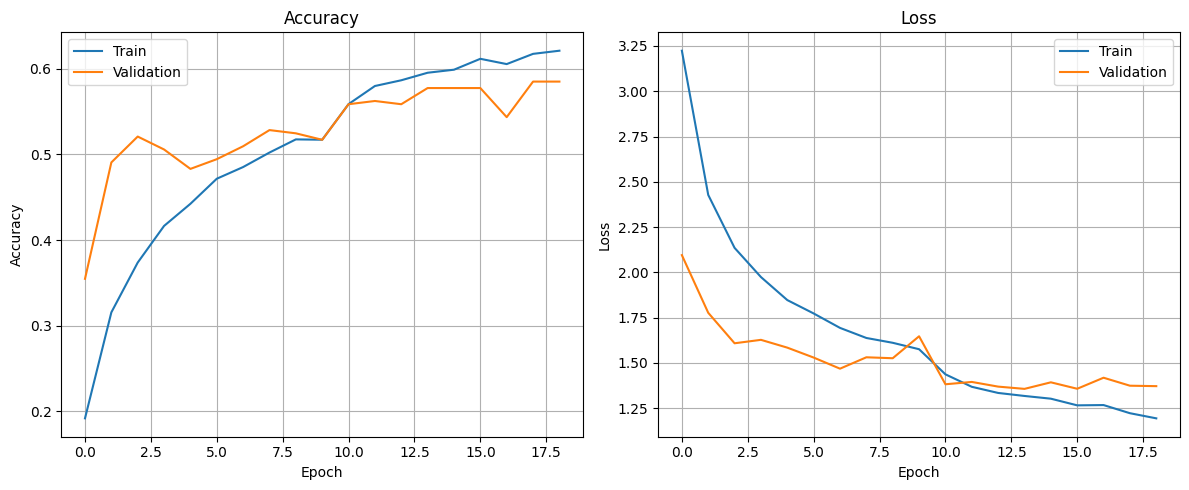

In [10]:
hist_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
hist_df[['accuracy', 'val_accuracy']].plot(ax=plt.gca())
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
hist_df[['loss', 'val_loss']].plot(ax=plt.gca())
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.grid(True)

plt.tight_layout()
plt.show()

## **5. Evaluación del modelo con TEST**

2/9 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8438 - loss: 0.5505 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.6365 - loss: 1.1552

Test Loss: 1.4534
Test Accuracy: 0.5434
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 371ms/step


<Figure size 2200x1000 with 0 Axes>

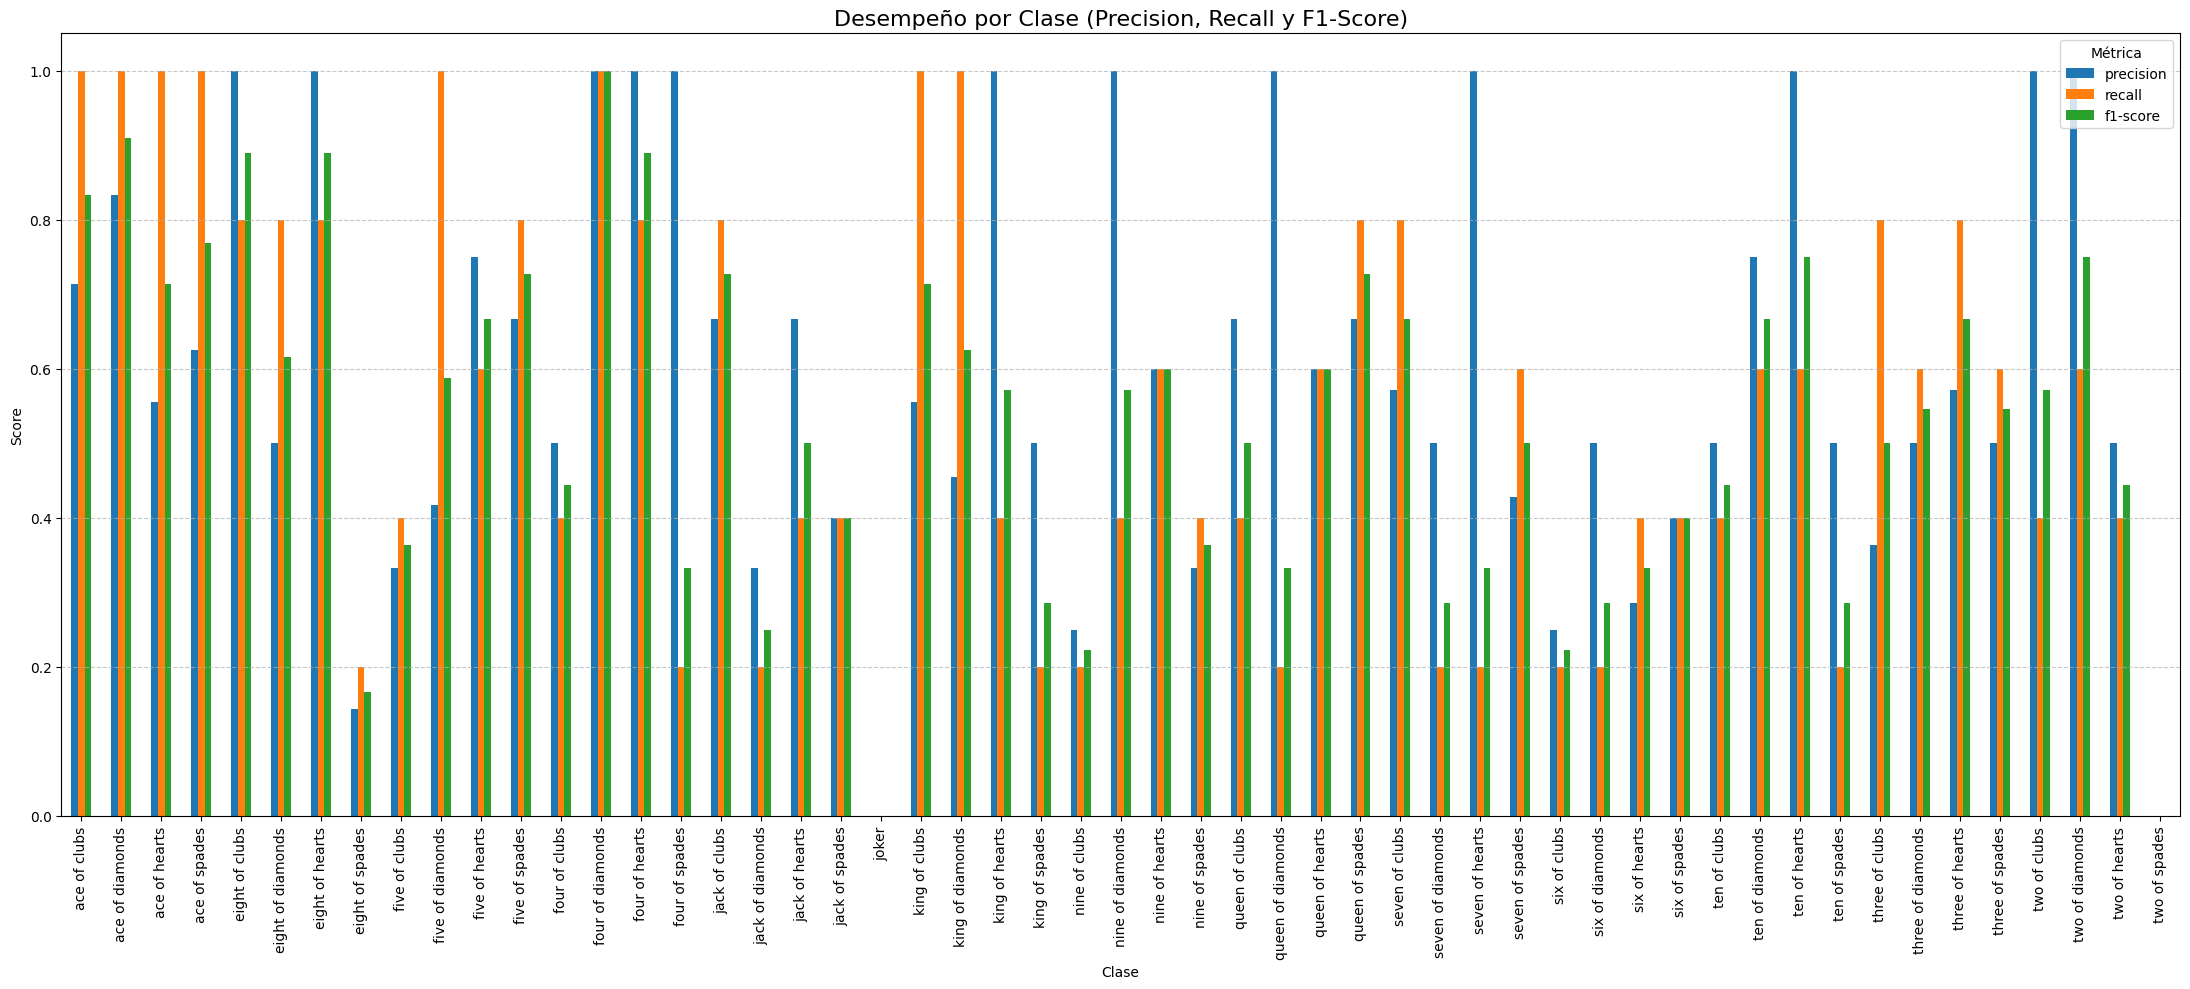

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

# Evaluación
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predicciones
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

# Reporte
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(index=['accuracy', 'macro avg', 'weighted avg'])

# Reorganizar
metrics = ['precision', 'recall', 'f1-score']
report_df = report_df[metrics]

# Gráfica de barras agrupadas
plt.figure(figsize=(22, 10))
report_df.plot(kind='bar', figsize=(22, 10))
plt.title("Desempeño por Clase (Precision, Recall y F1-Score)", fontsize=16)
plt.xlabel("Clase")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=90)
plt.legend(title="Métrica")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

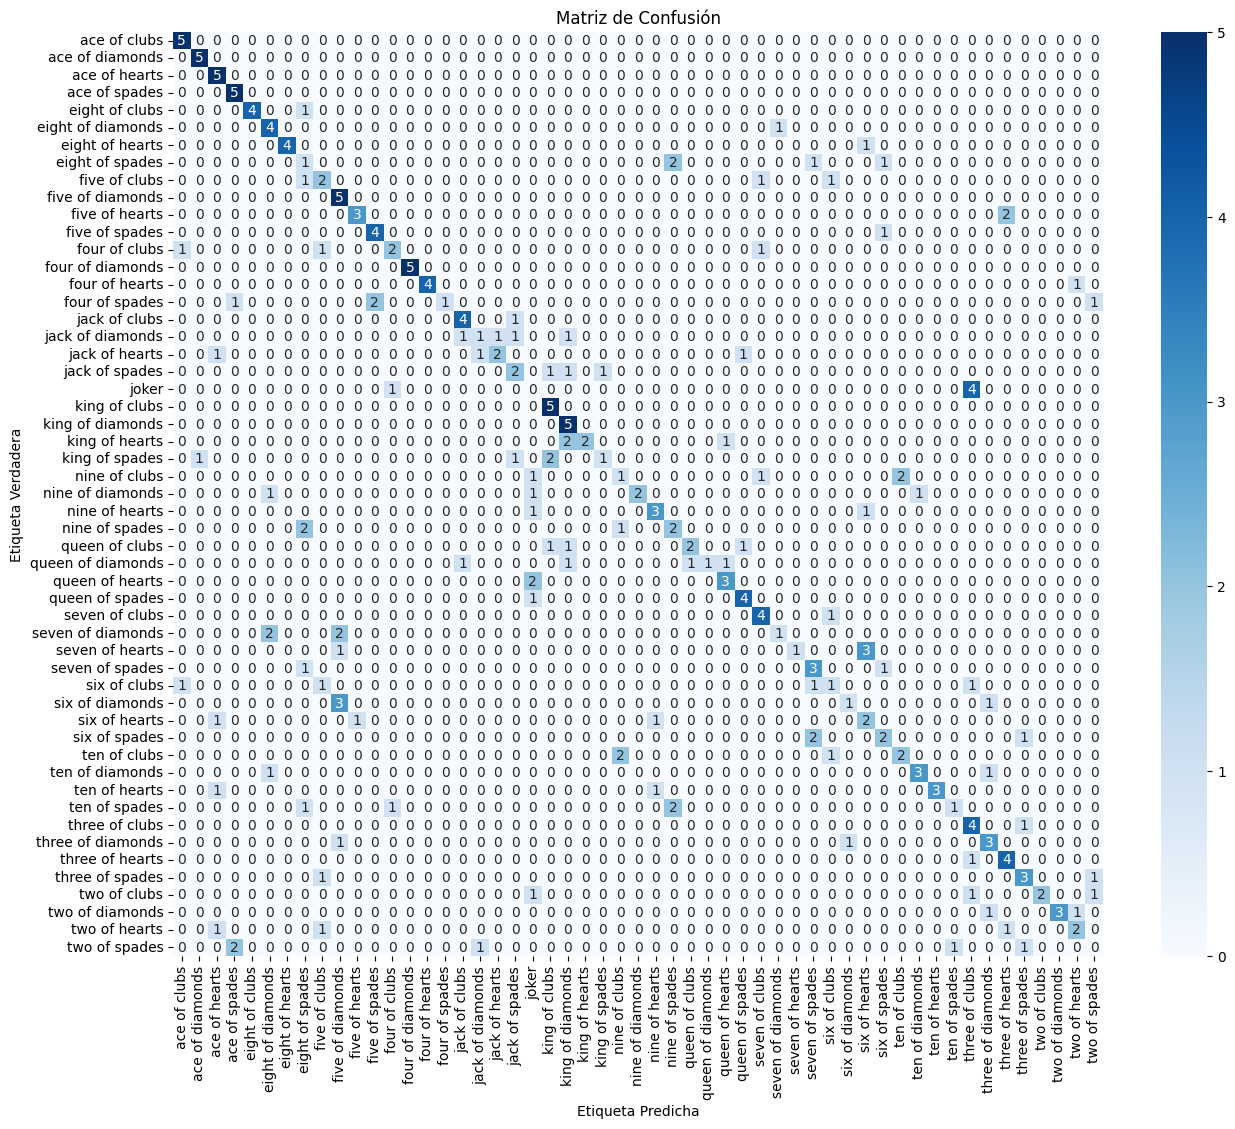

In [12]:
# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.ylabel("Etiqueta Verdadera")
plt.xlabel("Etiqueta Predicha")
plt.show()

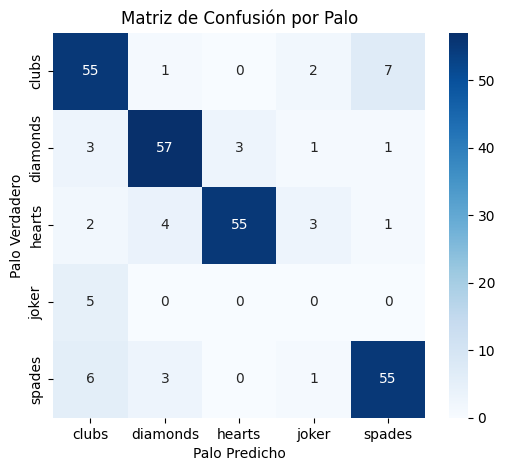

In [13]:
# Crear dataframe con las etiquetas verdaderas y predichas
df_results = pd.DataFrame({
    'true_label': [class_names[i] for i in y_true],
    'pred_label': [class_names[i] for i in y_pred]
})

# Funciones para extraer valor y palo
def get_value(card_name):
    return card_name.split(' ')[0]

def get_suit(card_name):
    return card_name.split(' ')[-1]

df_results['true_suit'] = df_results['true_label'].apply(get_suit)
df_results['pred_suit'] = df_results['pred_label'].apply(get_suit)
df_results['true_value'] = df_results['true_label'].apply(get_value)
df_results['pred_value'] = df_results['pred_label'].apply(get_value)

card_value_order = ['ace', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen', 'king', 'joker']

# Matriz por palo
suit_conf = pd.crosstab(df_results['true_suit'], df_results['pred_suit'])
plt.figure(figsize=(6,5))
sns.heatmap(suit_conf, annot=True, cmap="Blues", fmt="d")
plt.title("Matriz de Confusión por Palo")
plt.xlabel("Palo Predicho")
plt.ylabel("Palo Verdadero")
plt.show()

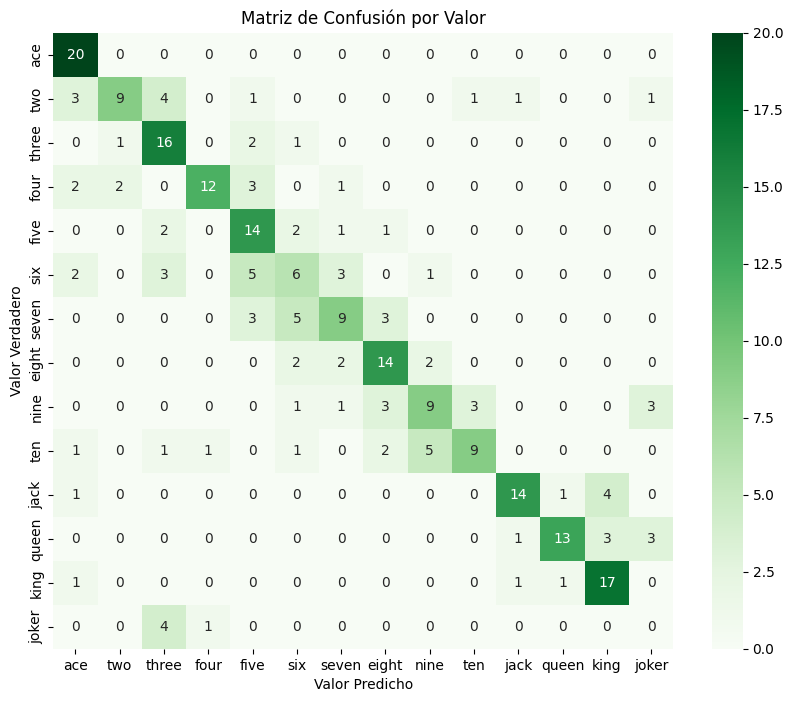

In [14]:
# Matriz por valor
value_conf = pd.crosstab(df_results['true_value'], df_results['pred_value'])
value_conf = value_conf.reindex(index=card_value_order, columns=card_value_order).fillna(0).astype(int)
plt.figure(figsize=(10,8))
sns.heatmap(value_conf, annot=True, cmap="Greens", fmt="d")
plt.title("Matriz de Confusión por Valor")
plt.xlabel("Valor Predicho")
plt.ylabel("Valor Verdadero")
plt.show()

Displaying 5 images for class: ace of spades


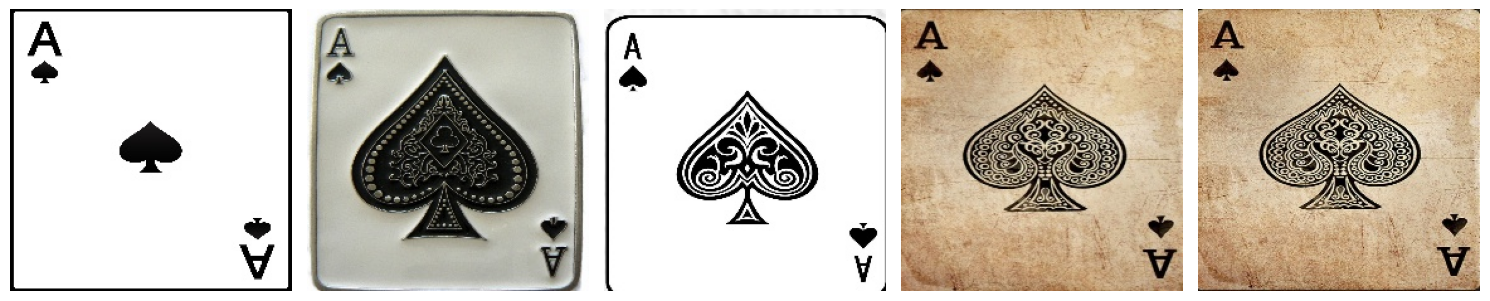

In [ ]:
def display_images_for_class(
        generator, 
        class_name, 
        num_images=5):
    """
    Muestra un número especificado de imágenes para una clase 
    dada de un ImageDataGenerator.

    Args:
        generator: El ImageDataGenerator del cual mostrar las imágenes.
        class_name: El nombre de la clase para mostrar imágenes.
        num_images: El número imágenes para mostrar en una sola fila.
    """
    class_index = generator.class_indices[class_name]
    images_displayed = 0

    print(f">> Mostrando {num_images} imágenes para la clase: {class_name}")

    plt.figure(figsize=(num_images * 3, 4))

    for i in range(len(generator)):
        images, labels = generator[i]
        for j in range(len(images)):
            if np.argmax(labels[j]) == class_index:
                plt.subplot(1, num_images, images_displayed + 1)
                plt.imshow(images[j])
                plt.axis('off')
                images_displayed += 1
                if images_displayed >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return

display_images_for_class(test_generator, 'ace of spades', num_images=5)

## **6. Guardado del modelo**

In [17]:
PROJECT_PATH = "/kaggle/working/"

model.save(PROJECT_PATH + "v7_classifier_model.h5")

with open(PROJECT_PATH + 'v7_history.json', 'w') as f:
    json.dump(history.history, f)